In [1]:
%%capture
%cd ..

In [2]:
from src.data import TimeSeriesGCNNDataset
from src.utils import Evaluator

from torch_geometric.loader import DataLoader
from torch_geometric.nn import summary

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import seaborn as sns
import pandas as pd

from tqdm.auto import tqdm



np.random.seed(42)  # For reproducible results
sns.set_theme("notebook", style="darkgrid", palette="flare")

WINDOW_SIZE = 24
TARGET_SIZE = 1
GRANULARITY = 12 # 5 minutes

EPOCHS = 100

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
METRICS = {
    "RMSE": root_mean_squared_error, 
    "MAE": mean_absolute_error,
    "MAPE": mean_absolute_percentage_error
}

## Understanding the data
The most complex and crucial task for this modelling is going to be to understand how the raw data is organized and how to format the training data.

### Raw data

In [3]:
pems8 = np.load("data/PEMS08/pems08.npz")["data"]
pems8.shape

(17856, 170, 3)

In [4]:
pems8_dist = pd.read_csv("data/PEMS08/distance.csv")
pems8_dist

,from,to,cost
0,9,153,310.6
1,153,62,330.9
2,62,111,332.9
3,111,11,324.2
4,11,28,336.0
...,...,...,...
290,154,5,166.3
291,78,107,143.9
292,107,46,236.3
293,118,145,250.6


In [5]:
pems4 = np.load("data/PEMS04/pems04.npz")["data"]
pems4.shape

(16992, 307, 3)

In [6]:
pems4_dist = pd.read_csv("data/PEMS04/distance.csv")
pems4_dist

,from,to,cost
0,73,5,352.6
1,5,154,347.2
2,154,263,392.9
3,263,56,440.8
4,56,96,374.6
...,...,...,...
335,46,216,353.6
336,217,98,411.7
337,98,31,3.2
338,217,46,354.0


above you can see the shape of the raw data. This is a numpy array with the following dimension:
- First Dimension (Time, 17856 obs): Represents different time steps in the dataset. Each "slice" of this dimension is a snapshot of the entire graph (e.g., traffic network) at a specific time.

- Second Dimension (Vertices/Nodes, 170 obs): Corresponds to the vertices or nodes in the graph. In this context, each node represent a different sensor within the traffic network.

- Third Dimension (Features, 3): Contains features or measurements for each vertex at each time step. The feature of this dataset are: **total flow**, **average occupancy** and **average speed**

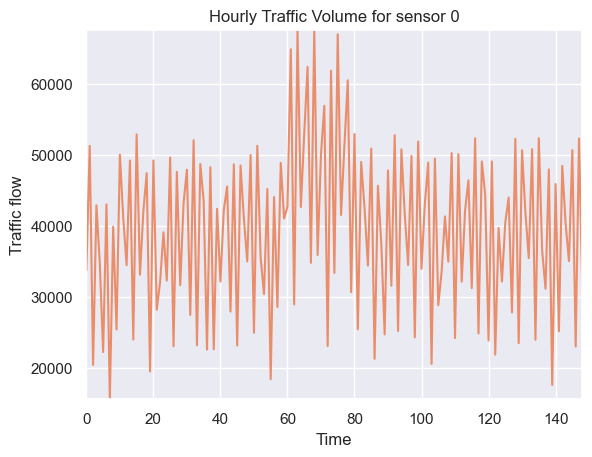

In [7]:
import matplotlib.pyplot as plt
from src.viz import viz_ts
import pandas as pd

traffic_flow = pems8[:, 0, 0]
timepoints = pd.date_range(start='2016-07-01', periods=len(traffic_flow), freq='30s')

df = pd.DataFrame({'Traffic Volume': traffic_flow}, index=timepoints)

hourly_df = df.resample('h').sum()

hourly_traffic_flow = hourly_df['Traffic Volume'].values
hourly_timepoints = hourly_df.index

fig, ax = viz_ts(hourly_traffic_flow,
                x_label="Time",
                y_label="Traffic flow",
                title="Hourly Traffic Volume for sensor 0")
plt.show()

### Training data generation
Now we are going to use the custom `TimeSeriesGCNNDataset` class to generate the data in a format suitable for feeding it into a traffic forecasting model.

In [8]:
traffic_dataset = TimeSeriesGCNNDataset(pems8[:, :, 0],
                                        pems8_dist[["from", "to"]].to_numpy(),
                                        pems8_dist[["cost"]].to_numpy(),
                                        window_size=WINDOW_SIZE,
                                        target_size=TARGET_SIZE,
                                        new_granularity=GRANULARITY) #to go from 30s to 1min

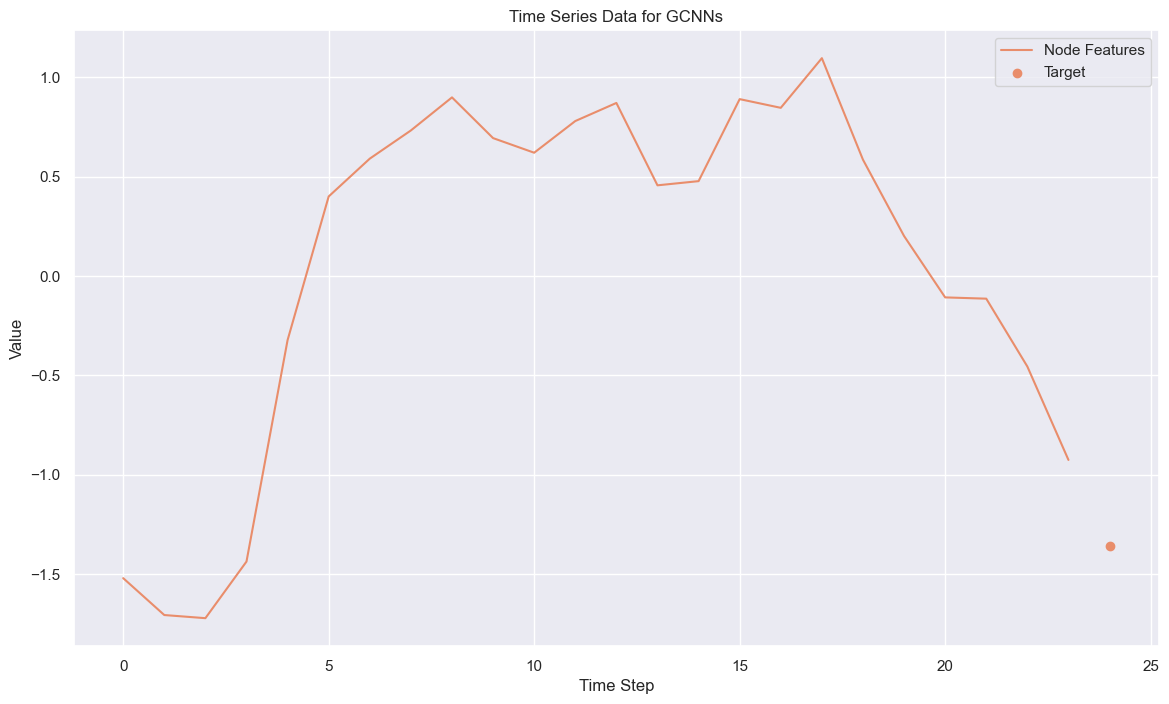

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

node_features = traffic_dataset[0].x
target = traffic_dataset[0].y

# Plotting with Seaborn
plt.figure(figsize=(14, 8))

# Plot the node_features
sns.lineplot(x=range(traffic_dataset.window_size), y=node_features[0, :].flatten(), label='Node Features')
plt.scatter(x=range(traffic_dataset.window_size, traffic_dataset.window_size+traffic_dataset.target_size), y=target[0, :].flatten(), label='Target')

plt.title('Time Series Data for GCNNs')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


## Training data

### Data preparation for training

In [10]:
from src.utils import create_loader

train_data_pems8, test_data_pems8, val_data_pems8 = create_train_test_split(pems8, 
                                                train_ratio=0.7,
                                                test_ratio = 0.2,
                                                window_size=WINDOW_SIZE,
                                                target_size=TARGET_SIZE)

train_dataset_pems8 = TimeSeriesGCNNDataset(train_data_pems8[:, :, 0],
                                    pems8_dist[["from", "to"]].to_numpy(),
                                    pems8_dist[["cost"]].to_numpy(),
                                    window_size=WINDOW_SIZE,
                                    target_size=TARGET_SIZE,
                                    new_granularity=GRANULARITY, 
                                    standardize=True)

test_dataset_pems8 = TimeSeriesGCNNDataset(test_data_pems8[:, :, 0],
                                    pems8_dist[["from", "to"]].to_numpy(),
                                    pems8_dist[["cost"]].to_numpy(),
                                    window_size=WINDOW_SIZE,
                                    target_size=TARGET_SIZE,
                                    new_granularity=GRANULARITY,
                                    standardize=True)

val_dataset_pems8 = TimeSeriesGCNNDataset(val_data_pems8[:, :, 0],
                                    pems8_dist[["from", "to"]].to_numpy(),
                                    pems8_dist[["cost"]].to_numpy(),
                                    window_size=WINDOW_SIZE,
                                    target_size=TARGET_SIZE,
                                    new_granularity=GRANULARITY,
                                    standardize=True)

train_loader_pems8 = DataLoader(train_dataset_pems8, batch_size=64, shuffle=True)
test_loader_pems8 = DataLoader(test_dataset_pems8, batch_size=64, shuffle=False)
val_loader_pems8 = DataLoader(val_dataset_pems8, batch_size=64, shuffle=False)

In [11]:
train_loader_pems4, test_loader_pems4, val_loader_pems4 = create_loader(val_data_pems4[:, :, 0],
                                                                        pems4_dist[["from", "to"]].to_numpy(),
                                                                        pems4_dist[["cost"]].to_numpy(),
                                                                        train_split=0.7,
                                                                        test_split=0.2,
                                                                        window_size=WINDOW_SIZE,
                                                                        target_size=TARGET_SIZE,
                                                                        new_granularity=GRANULARITY,
                                                                        batch_size=64,
                                                                        standardize=True)

In [12]:
len(train_dataset_pems8), len(test_dataset_pems8), len(val_dataset_pems8)

(1016, 272, 123)

In [13]:
len(train_dataset_pems4), len(test_dataset_pems4), len(val_dataset_pems4)

(966, 258, 116)

## Baseline models
For this project we are going to use two baseline models. For the first model we decided to go with a simple AIRMA model. We are going to use this model to serve as a benchmark for the forecasting ability of our model.

In this case we are not going to leverage the spatial feature, but rather we are going to create one AIRMA model for each sensor. 

To train these models we are going to assume that the parameters of the AIRMA are constant across sensors. This assumption is crucial to simplify the training process of the baseline since, even estimating the parameters of the airma for every series with an automatic estimation process is quite expensive and could take hours to do on a CPU. 

### Forecasting baseline

##### PEMS4

In [14]:
from src.utils import aggregate_time_series
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler

aggr_pems4 = aggregate_time_series(pems4, GRANULARITY, np.sum)[:, :, 0]

train_pems4, test_pems4, val_pems4 = create_train_test_split(aggr_pems4,
                                                             train_ratio=0.7,
                                                             test_ratio=0.2,
                                                             window_size=12,
                                                             target_size=1)

scaler = StandardScaler()
train_pems4 = scaler.fit_transform(train_pems4)
test_pems4 = scaler.transform(test_pems4)
val_pems4 = scaler.transform(val_pems4)

In [15]:
airma_eval = Evaluator(METRICS, save_history=False, save_best=False)
order = (3,0,1)

In [16]:
airmas_pems4 = []
train_loss_pems4 = []
test_loss__pems4 = []
val_loss_pems4 = []

for i in tqdm(range(pems4.shape[1])):
    model = ARIMA(train_pems4[:, i], order=order)
    model_fit = model.fit()


    train_loss_pems4.append(airma_eval.evaluate(train_pems4[:, i], model_fit.forecast(steps=len(train_pems4))))
    test_loss__pems4.append(airma_eval.evaluate(test_pems4[:, i], model_fit.forecast(steps=len(test_pems4))))
    val_loss_pems4.append(airma_eval.evaluate(val_pems4[:, i], model_fit.forecast(steps=len(val_pems4))))

    airmas_pems4.append(model_fit)

  0%|          | 0/307 [00:00<?, ?it/s]

/Users/vittorio/Library/Caches/pypoetry/virtualenvs/gnns-for-ts-zR-Www4t-py3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/vittorio/Library/Caches/pypoetry/virtualenvs/gnns-for-ts-zR-Www4t-py3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/vittorio/Library/Caches/pypoetry/virtualenvs/gnns-for-ts-zR-Www4t-py3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/vittorio/Library/Caches/pypoetry/virtualenvs/gnns-for-ts-zR-Www4t-py3.9/lib/python3.9/site-packages/statsmodels/base/model.py:

In [17]:
avg_rmse = np.mean([elem['RMSE'] for elem in test_loss__pems4])
avg_mae = np.mean([elem['MAE'] for elem in test_loss__pems4])
avg_mape = np.mean([elem['MAPE'] for elem in test_loss__pems4])

print(f"Average test RMSE: {avg_rmse:,.2f}")
print(f"Average test MAE: {avg_mae:,.2f}")
print(f"Average test MAPE:{avg_mape:,.2f}")


Average test RMSE: 0.99
Average test MAE: 0.87
Average test MAPE:1.07


##### PEMS8

In [18]:
aggr_pems8 = aggregate_time_series(pems8, GRANULARITY, np.sum)[:, :, 0]

train, test, val = create_train_test_split(aggr_pems8,
                                            train_ratio=0.7,
                                            test_ratio=0.2,
                                            window_size=12,
                                            target_size=1)

scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)
val = scaler.transform(val)

# estimated using auto_arima function
order = (3, 0, 1)

In [19]:
models = []
train_loss = []
test_loss = []
val_loss = []

for i in tqdm(range(pems8.shape[1])):
    model = ARIMA(train[:, i], order=order)
    model_fit = model.fit()


    train_loss.append(airma_eval.evaluate(train[:, i], model_fit.forecast(steps=len(train))))
    test_loss.append(airma_eval.evaluate(test[:, i], model_fit.forecast(steps=len(test))))
    val_loss.append(airma_eval.evaluate(val[:, i], model_fit.forecast(steps=len(val))))

    models.append(model_fit)
    

  0%|          | 0/170 [00:00<?, ?it/s]

/Users/vittorio/Library/Caches/pypoetry/virtualenvs/gnns-for-ts-zR-Www4t-py3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/vittorio/Library/Caches/pypoetry/virtualenvs/gnns-for-ts-zR-Www4t-py3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
import numpy as np

avg_rmse = np.mean([elem['RMSE'] for elem in test_loss])
avg_mae = np.mean([elem['MAE'] for elem in test_loss])
avg_mape = np.mean([elem['MAPE'] for elem in test_loss])

print(f"Average test RMSE: {avg_rmse:,.2f}")
print(f"Average test MAE: {avg_mae:,.2f}")
print(f"Average test MAPE:{avg_mape:,.2f}")


Average test RMSE: 1.02
Average test MAE: 0.86
Average test MAPE:1.15


### Baseline graph neural network
In this section instead we are going to create a baseline model for the graph neural network

In [21]:
from src.utils import compute_test_loss, train_model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
base_eval = Evaluator(METRICS, save_history=True, save_best=True, save_best_metric="RMSE")

#### PEMS4

In [22]:
from src.models import BaselineGCN

base_model_pems4 = BaselineGCN(train_dataset_pems4.window_size, train_dataset_pems4.target_size, hidden_channels=512)
print(summary(base_model_pems4, 
                train_dataset_pems4[0].x, 
                train_dataset_pems4[0].edge_index,
                train_dataset_pems4[0].edge_attr))

+------------------------------+-------------------------------+----------------+----------+
| Layer                        | Input Shape                   | Output Shape   | #Param   |
|------------------------------+-------------------------------+----------------+----------|
| BaselineGCN                  | [307, 24], [2, 340], [340, 1] | [307, 1]       | 13,313   |
| ├─(graph_convolution)GCNConv | [307, 24], [2, 340], [340, 1] | [307, 512]     | 12,800   |
| ├─(linear)Linear             | [307, 512]                    | [307, 1]       | 513      |
| ├─(activation)ReLU           | [307, 512]                    | [307, 512]     | --       |
+------------------------------+-------------------------------+----------------+----------+


In [23]:
base_model_pems4 = train_model(base_model_pems4, train_loader_pems4, val_loader_pems4, criterion, device, EPOCHS, 1e-4)

Epoch 1/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 2/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 3/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 4/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 5/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 6/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 7/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 8/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 9/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 10/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 11/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 12/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 13/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 14/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 15/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 16/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 17/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 18/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 19/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 20/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 21/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 22/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 23/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 24/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 25/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 26/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 27/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 28/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 29/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 30/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 31/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 32/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 33/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 34/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 35/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 36/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 37/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 38/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 39/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 40/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 41/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 42/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 43/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 44/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 45/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 46/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 47/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 48/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 49/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 50/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 51/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 52/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 53/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 54/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 55/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 56/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 57/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 58/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 59/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 60/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 61/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 62/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 63/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 64/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 65/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 66/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 67/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 68/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 69/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 70/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 71/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 72/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 73/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 74/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 75/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 76/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 77/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 78/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 79/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 80/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 81/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 82/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 83/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 84/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 85/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 86/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 87/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 88/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 89/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 90/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 91/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 92/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 93/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 94/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 95/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 96/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 97/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 98/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 99/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 100/100:   0%|          | 0/16 [00:00<?, ?batch/s]

In [24]:
eval_results = base_eval.evaluate_dataloader(test_loader_pems4, base_model_pems4, device);eval_results

{'RMSE': 1.2326784, 'MAE': 1.2041445, 'MAPE': 1.0019001}

#### PEMS8

In [25]:
base_model_pems8 = BaselineGCN(train_dataset_pems8.window_size, train_dataset_pems8.target_size, hidden_channels=512)
print(summary(base_model_pems8, 
                train_dataset_pems8[0].x, 
                train_dataset_pems8[0].edge_index,
                train_dataset_pems8[0].edge_attr))

+------------------------------+-------------------------------+----------------+----------+
| Layer                        | Input Shape                   | Output Shape   | #Param   |
|------------------------------+-------------------------------+----------------+----------|
| BaselineGCN                  | [170, 24], [2, 295], [295, 1] | [170, 1]       | 13,313   |
| ├─(graph_convolution)GCNConv | [170, 24], [2, 295], [295, 1] | [170, 512]     | 12,800   |
| ├─(linear)Linear             | [170, 512]                    | [170, 1]       | 513      |
| ├─(activation)ReLU           | [170, 512]                    | [170, 512]     | --       |
+------------------------------+-------------------------------+----------------+----------+


In [26]:
base_model_pems8 = train_model(base_model_pems8, train_loader_pems8, val_loader_pems8, criterion, device, EPOCHS, 1e-4)

Epoch 1/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 2/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 3/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 4/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 5/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 6/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 7/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 8/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 9/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 10/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 11/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 12/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 13/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 14/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 15/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 16/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 17/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 18/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 19/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 20/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 21/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 22/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 23/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 24/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 25/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 26/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 27/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 28/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 29/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 30/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 31/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 32/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 33/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 34/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 35/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 36/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 37/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 38/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 39/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 40/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 41/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 42/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 43/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 44/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 45/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 46/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 47/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 48/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 49/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 50/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 51/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 52/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 53/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 54/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 55/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 56/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 57/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 58/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 59/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 60/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 61/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 62/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 63/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 64/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 65/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 66/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 67/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 68/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 69/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 70/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 71/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 72/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 73/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 74/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 75/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 76/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 77/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 78/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 79/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 80/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 81/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 82/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 83/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 84/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 85/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 86/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 87/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 88/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 89/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 90/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 91/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 92/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 93/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 94/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 95/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 96/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 97/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 98/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 99/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 100/100:   0%|          | 0/16 [00:00<?, ?batch/s]

In [27]:
eval_results = base_eval.evaluate_dataloader(test_loader_pems8, base_model_pems8, device);eval_results

{'RMSE': 0.74267995, 'MAE': 0.4975467, 'MAPE': 1.2293326}

In [28]:
from src.viz import plot_predictions
timestep_to_predict = 3
index_to_predict = 0
# Set the model to evaluation mode
model.eval()

# Move the model to the device
model = model.to(device)

# Move the data to the device
batch = batch.to(device)

dataset = test_dataset

obs = dataset[timestep_to_predict]

# Disable gradient computation
with torch.no_grad():
    # Forward pass
    output = model(obs.x, obs.edge_index, obs.edge_weight)

# Move the output and target to the CPU
output = output.cpu().flatten()
target = obs.y.cpu().flatten()


true_x = dataset._inverse_standardize_data(obs.x)[index_to_predict]
pred_y = dataset._inverse_standardize_data(output[:, np.newaxis])[index_to_predict]
true_y = dataset._inverse_standardize_data(target[:, np.newaxis])[index_to_predict]


plot_predictions(true_x, true_y, pred_y,
                 WINDOW_SIZE, TARGET_SIZE)


'from src.viz import plot_predictions\ntimestep_to_predict = 3\nindex_to_predict = 0\n# Set the model to evaluation mode\nmodel.eval()\n\n# Move the model to the device\nmodel = model.to(device)\n\n# Move the data to the device\nbatch = batch.to(device)\n\ndataset = test_dataset\n\nobs = dataset[timestep_to_predict]\n\n# Disable gradient computation\nwith torch.no_grad():\n    # Forward pass\n    output = model(obs.x, obs.edge_index, obs.edge_weight)\n\n# Move the output and target to the CPU\noutput = output.cpu().flatten()\ntarget = obs.y.cpu().flatten()\n\n\ntrue_x = dataset._inverse_standardize_data(obs.x)[index_to_predict]\npred_y = dataset._inverse_standardize_data(output[:, np.newaxis])[index_to_predict]\ntrue_y = dataset._inverse_standardize_data(target[:, np.newaxis])[index_to_predict]\n\n\nplot_predictions(true_x, true_y, pred_y,\n                 WINDOW_SIZE, TARGET_SIZE)'

In [29]:
from src.viz import plot_predictions
timestep_to_predict = 0
index_to_predict = 0
# Set the model to evaluation mode
model.eval()

# Move the model to the device
model = model.to(device)

# Move the data to the device
batch = batch.to(device)

obs = dataset[timestep_to_predict]

# Disable gradient computation
with torch.no_grad():
    # Forward pass
    output = model(obs.x, obs.edge_index, obs.edge_weight)

# Move the output and target to the CPU
output = output.cpu().flatten()
target = obs.y.cpu().flatten()


true_x = dataset._inverse_standardize_data(obs.x)[index_to_predict]
pred_y = dataset._inverse_standardize_data(output[:, np.newaxis])[index_to_predict]
true_y = dataset._inverse_standardize_data(target[:, np.newaxis])[index_to_predict]


plot_predictions(true_x, true_y, pred_y,
                 WINDOW_SIZE, TARGET_SIZE)

'from src.viz import plot_predictions\ntimestep_to_predict = 0\nindex_to_predict = 0\n# Set the model to evaluation mode\nmodel.eval()\n\n# Move the model to the device\nmodel = model.to(device)\n\n# Move the data to the device\nbatch = batch.to(device)\n\ndataset = test_dataset\n\nobs = dataset[timestep_to_predict]\n\n# Disable gradient computation\nwith torch.no_grad():\n    # Forward pass\n    output = model(obs.x, obs.edge_index, obs.edge_weight)\n\n# Move the output and target to the CPU\noutput = output.cpu().flatten()\ntarget = obs.y.cpu().flatten()\n\n\ntrue_x = dataset._inverse_standardize_data(obs.x)[index_to_predict]\npred_y = dataset._inverse_standardize_data(output[:, np.newaxis])[index_to_predict]\ntrue_y = dataset._inverse_standardize_data(target[:, np.newaxis])[index_to_predict]\n\n\nplot_predictions(true_x, true_y, pred_y,\n                 WINDOW_SIZE, TARGET_SIZE)'

## More complex model architectures

In [30]:
from src.models import MultiLayerGCN, GCNLayer, GCNLSTMCell

model_1 = MultiLayerGCN(
    num_features=WINDOW_SIZE, 
    num_features_out=TARGET_SIZE,
    layer_configs=[
        {'type': GCNLayer, 'out_channels': 128}
    ],
    linear_layers=[128],  # Single linear layer
    dropout=0.1  # Example dropout rate
)

# Model 2: More complex GCNConv model with two GCN layers
model_2 = MultiLayerGCN(
    num_features=WINDOW_SIZE, 
    num_features_out=TARGET_SIZE,
    layer_configs=[
        {'type': GCNLayer, 'out_channels': 128},
        {'type': GCNLayer, 'out_channels': 256}  # Additional GCN layer with more features
    ],
    linear_layers=[256],
    dropout=0.1
)

In [31]:
print(summary(model_1, 
              traffic_dataset[0].x, 
              traffic_dataset[0].edge_index, 
              traffic_dataset[0].edge_attr))

+-------------------------------------+-------------------------------+----------------+----------+
| Layer                               | Input Shape                   | Output Shape   | #Param   |
|-------------------------------------+-------------------------------+----------------+----------|
| MultiLayerGCN                       | [170, 24], [2, 295], [295, 1] | [170, 1]       | 19,841   |
| ├─(layers)ModuleList                | --                            | --             | 3,200    |
| │    └─(0)GCNLayer                  | [170, 24], [2, 295], [295, 1] | [170, 128]     | 3,200    |
| │    │    └─(conv)GCNConv           | [170, 24], [2, 295], [295, 1] | [170, 128]     | 3,200    |
| │    │    └─(normalization)Identity | [170, 128]                    | [170, 128]     | --       |
| │    │    └─(activation)ReLU        | [170, 128]                    | [170, 128]     | --       |
| ├─(linear_layers)Sequential         | [170, 128]                    | [170, 1]       | 16,641   |


In [32]:
print(summary(model_2, 
              traffic_dataset[0].x, 
              traffic_dataset[0].edge_index, 
              traffic_dataset[0].edge_attr))

+-------------------------------------+--------------------------------+----------------+----------+
| Layer                               | Input Shape                    | Output Shape   | #Param   |
|-------------------------------------+--------------------------------+----------------+----------|
| MultiLayerGCN                       | [170, 24], [2, 295], [295, 1]  | [170, 1]       | 102,273  |
| ├─(layers)ModuleList                | --                             | --             | 36,224   |
| │    └─(0)GCNLayer                  | [170, 24], [2, 295], [295, 1]  | [170, 128]     | 3,200    |
| │    │    └─(conv)GCNConv           | [170, 24], [2, 295], [295, 1]  | [170, 128]     | 3,200    |
| │    │    └─(normalization)Identity | [170, 128]                     | [170, 128]     | --       |
| │    │    └─(activation)ReLU        | [170, 128]                     | [170, 128]     | --       |
| │    └─(1)GCNLayer                  | [170, 128], [2, 295], [295, 1] | [170, 256]     | 3

#### Model 1

##### Pems4

In [33]:
model_1_pems4 = train_model(model_1, train_loader_pems4, val_loader_pems4, criterion, device, epochs=EPOCHS, batch_size=64, learning_rate=1e-4, patience=5, min_delta=0.0005)

Epoch 1/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 2/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 3/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 4/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 5/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 6/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 7/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 8/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 9/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 10/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 11/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 12/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 13/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 14/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 15/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 16/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 17/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 18/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 19/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 20/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 21/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 22/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 23/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 24/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 25/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 26/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 27/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 28/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 29/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 30/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 31/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 32/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 33/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 34/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 35/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 36/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 37/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 38/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 39/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 40/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 41/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 42/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 43/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 44/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 45/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 46/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 47/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 48/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 49/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 50/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 51/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 52/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 53/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 54/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 55/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 56/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 57/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 58/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 59/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 60/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 61/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 62/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 63/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 64/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 65/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 66/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 67/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 68/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 69/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 70/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 71/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 72/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 73/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 74/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 75/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 76/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 77/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 78/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 79/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 80/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 81/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 82/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 83/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 84/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 85/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 86/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 87/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 88/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 89/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 90/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 91/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 92/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 93/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 94/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 95/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 96/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 97/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 98/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 99/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 100/100:   0%|          | 0/16 [00:00<?, ?batch/s]

In [34]:
eval_results = base_eval.evaluate_dataloader(test_loader_pems4, model_1_pems4, device);eval_results

{'RMSE': 0.19777817, 'MAE': 0.14447322, 'MAPE': 0.17953613}

##### Pems8

In [35]:
model_1_pems8 = train_model(model_1, train_loader_pems8, val_loader_pems8, criterion, device, epochs=EPOCHS, batch_size=64, learning_rate=1e-4, patience=5, min_delta=0.0005)

Epoch 1/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 2/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 3/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 4/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 5/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 6/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 7/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 8/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 9/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 10/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 11/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 12/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 13/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 14/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 15/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 16/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 17/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 18/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 19/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 20/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 21/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 22/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 23/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 24/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 25/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 26/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 27/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 28/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 29/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 30/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 31/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 32/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 33/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 34/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 35/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 36/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 37/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 38/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 39/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 40/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 41/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 42/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 43/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 44/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 45/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 46/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 47/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 48/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 49/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 50/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 51/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 52/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 53/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 54/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 55/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 56/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 57/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 58/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 59/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 60/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 61/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 62/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 63/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 64/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 65/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 66/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 67/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 68/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 69/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 70/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 71/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 72/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 73/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 74/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 75/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 76/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 77/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 78/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 79/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 80/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 81/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 82/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 83/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 84/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 85/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 86/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 87/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 88/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 89/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 90/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 91/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 92/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 93/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 94/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 95/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 96/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 97/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 98/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 99/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 100/100:   0%|          | 0/16 [00:00<?, ?batch/s]

In [36]:
eval_results = base_eval.evaluate_dataloader(test_loader_pems8, model_1_pems8, device);eval_results

{'RMSE': 0.34748393, 'MAE': 0.23777601, 'MAPE': 1.3041214}

#### Model 2

##### Pems4

In [37]:
model_2_pems4 = train_model(model_2, train_loader_pems4, val_loader_pems4, criterion, device, epochs=EPOCHS, batch_size=64, learning_rate=1e-4, patience=5, min_delta=0.0005)

Epoch 1/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 2/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 3/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 4/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 5/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 6/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 7/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 8/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 9/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 10/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 11/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 12/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 13/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 14/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 15/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 16/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 17/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 18/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 19/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 20/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 21/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 22/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 23/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 24/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 25/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 26/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 27/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 28/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 29/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 30/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 31/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 32/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 33/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 34/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 35/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 36/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 37/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 38/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 39/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 40/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 41/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 42/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 43/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 44/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 45/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 46/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 47/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 48/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 49/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 50/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 51/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 52/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 53/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 54/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 55/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 56/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 57/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 58/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 59/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 60/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 61/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 62/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 63/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 64/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 65/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 66/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 67/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 68/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 69/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 70/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 71/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 72/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 73/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 74/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 75/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 76/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 77/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 78/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 79/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 80/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 81/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 82/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 83/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 84/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 85/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 86/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 87/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 88/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 89/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 90/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 91/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 92/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 93/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 94/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 95/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 96/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 97/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 98/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 99/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 100/100:   0%|          | 0/16 [00:00<?, ?batch/s]

In [38]:
eval_results = base_eval.evaluate_dataloader(test_loader_pems4, model_2_pems4, device);eval_results

{'RMSE': 0.21079949, 'MAE': 0.15778582, 'MAPE': 0.20211445}

##### Pems8

In [39]:
model_2_pems8 = train_model(model_2, train_loader_pems8, val_loader_pems8, criterion, device, epochs=EPOCHS, batch_size=64, learning_rate=1e-4, patience=5, min_delta=0.0005)

Epoch 1/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 2/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 3/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 4/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 5/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 6/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 7/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 8/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 9/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 10/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 11/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 12/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 13/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 14/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 15/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 16/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 17/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 18/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 19/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 20/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 21/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 22/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 23/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 24/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 25/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 26/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 27/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 28/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 29/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 30/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 31/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 32/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 33/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 34/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 35/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 36/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 37/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 38/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 39/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 40/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 41/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 42/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 43/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 44/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 45/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 46/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 47/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 48/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 49/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 50/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 51/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 52/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 53/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 54/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 55/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 56/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 57/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 58/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 59/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 60/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 61/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 62/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 63/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 64/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 65/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 66/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 67/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 68/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 69/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 70/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 71/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 72/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 73/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 74/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 75/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 76/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 77/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 78/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 79/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 80/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 81/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 82/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 83/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 84/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 85/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 86/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 87/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 88/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 89/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 90/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 91/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 92/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 93/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 94/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 95/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 96/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 97/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 98/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 99/100:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 100/100:   0%|          | 0/16 [00:00<?, ?batch/s]

In [40]:
eval_results = base_eval.evaluate_dataloader(test_loader_pems8, model_2_pems8, device);eval_results

{'RMSE': 0.3791776, 'MAE': 0.26105368, 'MAPE': 1.5840213}

# Implementing diffusion process

In [27]:
from src.models import DCRNN

dcrnn_model = DCRNN(WINDOW_SIZE, 
                    TARGET_SIZE, K = 1)

In [28]:
dcrnn_model_pems4 = train_model(dcrnn_model, train_loader_pems4, val_loader_pems4, criterion, device, epochs=EPOCHS, batch_size=64, learning_rate=1e-4, patience=5, min_delta=0.0005)

Epoch 1/50:   0%|          | 0/16 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [26]:
eval_results = base_eval.evaluate_dataloader(test_loader_pems4, dcrnn_model_pems4, device);eval_results

NameError: name 'dcrnn_model_pems8' is not defined

In [ ]:
dcrnn_model_pems8 = train_model(dcrnn_model, train_loader_pems8, val_loader_pems8, criterion, device, epochs=EPOCHS, batch_size=64, learning_rate=1e-4, patience=5, min_delta=0.0005)

In [ ]:
eval_results = base_eval.evaluate_dataloader(test_loader_pems8, dcrnn_model_pems8, device);eval_results

NameError: name 'dcrnn_model_pems8' is not defined

In [46]:
for param in model_2_pems4.layers[1].conv.parameters():
    print(param)

Parameter containing:
tensor([ 6.3913e-02,  7.0739e-02, -6.9883e-02,  5.9894e-02,  5.3788e-02,
         7.7176e-02, -3.6285e-02,  5.4634e-02,  7.1529e-02, -3.3003e-02,
         5.6546e-03, -9.0275e-02,  8.6976e-02,  2.8811e-02, -4.7911e-02,
         1.3066e-01,  7.7521e-02, -8.8512e-03, -5.3300e-02, -4.9524e-03,
        -2.9080e-02,  1.7272e-02,  5.0630e-02,  1.1661e-01, -9.2367e-02,
         1.1667e-01, -2.2479e-02, -4.6981e-02,  2.3723e-02,  9.5094e-02,
         5.8435e-03,  1.1568e-02,  1.0433e-01, -4.6764e-02,  2.2618e-02,
        -5.0254e-02,  9.6890e-02, -8.4771e-03,  6.2011e-02, -5.6625e-02,
         4.7277e-02, -3.5334e-02,  6.0483e-03,  1.0605e-02, -4.1078e-02,
         4.9363e-02, -3.7145e-02,  2.2045e-02,  8.2994e-02,  7.5307e-02,
         1.0497e-01,  7.6086e-02,  9.6875e-02,  2.5449e-02,  2.4669e-02,
        -1.1402e-02,  6.1460e-02, -8.4156e-03,  6.4295e-02,  5.3744e-02,
         1.4569e-04,  8.6442e-02, -5.8827e-02, -2.4657e-02,  5.1342e-02,
         4.4693e-02,  6.3561e

In [49]:
param

Parameter containing:
tensor([[ 0.0299,  0.0721,  0.1066,  ...,  0.1133, -0.0503, -0.0563],
        [ 0.0052,  0.0190,  0.0403,  ..., -0.0164,  0.0898,  0.0562],
        [ 0.0824, -0.0385,  0.0260,  ...,  0.0160,  0.0879, -0.0633],
        ...,
        [-0.0217, -0.0355,  0.1128,  ..., -0.0895,  0.0976, -0.0082],
        [ 0.0746,  0.0316,  0.0135,  ...,  0.0040, -0.0845,  0.1172],
        [ 0.1062, -0.0335,  0.0663,  ...,  0.0869,  0.0967,  0.1254]],
       requires_grad=True)

In [50]:
for param in model_1_pems4.layers[0].conv.parameters():
    print(param)

Parameter containing:
tensor([ 7.2528e-02, -7.0654e-02,  7.8906e-02,  6.6372e-02, -3.3872e-02,
         4.2049e-02,  1.1280e-01,  1.0205e-01,  5.5367e-04,  7.5825e-02,
         9.6457e-02,  9.0889e-02,  1.0378e-01, -1.4928e-02, -8.6093e-02,
        -3.0919e-02,  9.4472e-02, -3.1745e-02,  6.6861e-02,  2.1193e-02,
        -7.0288e-03,  9.3246e-02,  2.2284e-02, -4.9040e-02,  1.0330e-01,
        -2.9230e-05,  6.3322e-03,  2.9365e-02,  5.9906e-02,  4.0475e-02,
         9.7868e-02, -1.2265e-01,  5.7404e-02,  4.5041e-02,  5.2341e-02,
         9.2558e-02,  7.7471e-02, -9.6987e-03,  1.0376e-01, -7.1606e-02,
         1.1579e-02,  7.1327e-03,  5.6569e-02, -7.7252e-02,  7.2955e-02,
         3.4479e-02,  8.6118e-02,  2.4605e-02,  8.7218e-02,  1.0339e-01,
        -8.7099e-02, -4.0212e-02,  1.3709e-02,  6.5026e-02,  8.2744e-02,
         2.8437e-02,  1.9417e-02,  1.4478e-02,  3.3345e-02,  7.7266e-02,
        -6.2357e-02, -7.1372e-02,  1.0927e-01,  4.4162e-02, -3.0783e-02,
         4.7844e-02, -3.8873e